In [1]:
#Import necessary libraries for data manipulation and mapping using geomstats. 
import joblib 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns', 40)

import torch 
from torch_geometric.data import Dataset, Data 

# from pyriemann.tangentspace import TangentSpace
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler 
# from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib 
from nilearn.connectome import ConnectivityMeasure

d:\WIDS\hacks_wids\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Read the training data 
df_train = pd.read_csv('TRAIN\TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
df_train.head() 

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,0throw_11thcolumn,0throw_12thcolumn,0throw_13thcolumn,0throw_14thcolumn,0throw_15thcolumn,0throw_16thcolumn,0throw_17thcolumn,0throw_18thcolumn,0throw_19thcolumn,...,193throw_195thcolumn,193throw_196thcolumn,193throw_197thcolumn,193throw_198thcolumn,193throw_199thcolumn,194throw_195thcolumn,194throw_196thcolumn,194throw_197thcolumn,194throw_198thcolumn,194throw_199thcolumn,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.222930,0.527903,0.429966,0.060457,0.566489,0.315342,0.508408,-0.078290,0.525692,0.470063,0.344990,0.061988,-0.004754,0.087006,0.062536,0.019368,-0.264989,0.010284,-0.048986,...,0.320795,0.097675,-0.113578,0.060867,-0.311772,0.266676,0.249678,-0.133153,0.248229,-0.184570,0.224985,0.397448,0.422966,0.184642,0.305549,0.420349,0.016328,0.561864,0.471170,0.365221
1,WHWymJu6zNZi,0.614765,0.577255,0.496127,0.496606,0.404686,0.439724,0.122590,-0.085452,0.120673,0.276350,0.076671,-0.355816,-0.378783,0.013883,-0.454740,-0.140388,0.096217,0.019166,0.188470,...,0.241392,-0.015846,-0.263051,0.005492,-0.259451,0.397901,0.199323,-0.079072,0.187434,-0.189790,0.217546,-0.014549,0.000440,-0.096451,0.454501,0.343916,0.167313,0.607656,0.550623,0.503176
2,4PAQp1M6EyAo,-0.116833,0.458408,0.260703,0.639031,0.769337,0.442528,0.637110,0.192010,0.520379,0.378557,0.469188,-0.192733,-0.183192,-0.250017,-0.315091,-0.153318,-0.254021,-0.108978,-0.212169,...,0.321061,0.111052,0.132341,-0.082926,-0.022957,0.349295,0.070137,0.058352,-0.152907,-0.074773,0.342487,-0.021141,-0.037836,0.075069,0.412712,0.292708,0.391005,0.461544,0.508912,0.624232
3,obEacy4Of68I,0.199688,0.752714,0.658283,0.575096,0.692867,0.645789,0.522750,0.412188,0.530843,0.259596,0.671093,-0.154625,0.130466,0.129043,0.016984,-0.031937,-0.129886,-0.068365,-0.066245,...,0.371668,0.438980,-0.158728,0.347941,-0.189850,0.390913,0.352199,-0.292561,0.111700,-0.347116,0.103562,-0.178313,0.210983,-0.018666,0.436313,0.592982,0.216205,0.341272,0.440313,0.558193
4,s7WzzDcmDOhF,0.227321,0.613268,0.621447,0.562673,0.736709,0.589813,0.266676,0.359668,0.300771,0.331445,0.509199,-0.108351,0.014970,0.123133,0.007104,-0.113080,-0.126452,0.130758,0.137167,...,0.545038,-0.123111,0.058722,0.346353,-0.255614,0.554783,0.162034,0.103062,-0.267779,-0.302240,-0.164956,0.007064,-0.120904,-0.488095,0.493575,-0.215361,0.210685,0.055850,0.119065,0.108273


In [ ]:
def process_to_tangent_space(df, return_measure=False):
    """
    Convert lower-triangular DataFrame to tangent space features.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with participant_id and lower-triangular connectivity values.
    return_measure : bool, optional
        Whether to return the fitted ConnectivityMeasure object (for test data).
        
    Returns
    -------
    pd.DataFrame or tuple
        - If return_measure=False: Returns tangent space DataFrame
        - If return_measure=True: Returns (DataFrame, fitted_measure)
    """
    # Extract participant IDs and lower triangular data
    participant_ids = df['participant_id']
    lower_tri_data = df.drop(columns=['participant_id']).values
    
    # Validate matrix dimensions
    n_subjects = len(df)
    n_regions = 200  # For 200x200 matrices
    n_connections = lower_tri_data.shape[1]
    expected_connections = (n_regions * (n_regions - 1)) // 2
    
    if n_connections != expected_connections:
        raise ValueError(
            f"Expected {expected_connections} connections for {n_regions}x{n_regions} matrix, "
            f"got {n_connections}"
        )
    
    # Reconstruct full symmetric matrices (diagonal=1)
    full_matrices = np.zeros((n_subjects, n_regions, n_regions))
    triu_indices = np.triu_indices(n_regions, k=1)  # Upper tri indices (no diagonal)
    
    for i in range(n_subjects):
        mat = np.eye(n_regions)  # Diagonal=1
        mat[triu_indices] = lower_tri_data[i]  # Fill upper triangle
        mat = mat + mat.T - np.eye(n_regions)  # Mirror to lower triangle
        full_matrices[i] = mat
    
    # Fit tangent space transformer
    tangent_measure = ConnectivityMeasure(
        kind="tangent",
        standardize="zscore_sample",  
    )
    tangent_features = tangent_measure.fit_transform(full_matrices)
    
    # Extract lower triangular part (to match input format)
    tril_indices = np.tril_indices(n_regions, k=-1)  # Lower tri (no diagonal)
    tangent_lower_tri = np.array([mat[tril_indices] for mat in tangent_features])
    
    # Reconstruct output DataFrame
    result_df = pd.DataFrame(
        tangent_lower_tri,
        columns=df.columns[1:]  # Preserve original column names
    )
    result_df.insert(0, 'participant_id', participant_ids)
    
    if return_measure:
        return result_df, tangent_measure
    else:
        return result_df

In [5]:
tangent_df, tangent_measure = process_to_tangent_space(df_train, return_measure=True)

from joblib import dump
dump(tangent_measure, 'tangent_measure.joblib')

d:\WIDS\hacks_wids\lib\site-packages\nilearn\connectome\connectivity_matrices.py:203: UserWarning: Maximum number of iterations 30 reached without getting to the requested tolerance level 1e-07.
  warnings.warn(


['tangent_measure.joblib']

In [6]:
tangent_df.head()

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,0throw_11thcolumn,0throw_12thcolumn,0throw_13thcolumn,0throw_14thcolumn,0throw_15thcolumn,0throw_16thcolumn,0throw_17thcolumn,0throw_18thcolumn,0throw_19thcolumn,...,193throw_195thcolumn,193throw_196thcolumn,193throw_197thcolumn,193throw_198thcolumn,193throw_199thcolumn,194throw_195thcolumn,194throw_196thcolumn,194throw_197thcolumn,194throw_198thcolumn,194throw_199thcolumn,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.101022,0.054926,-0.154772,0.096214,0.249178,-0.198960,-0.094001,0.151208,-0.174601,-0.007791,0.141762,0.041745,-0.028348,0.133192,-0.202025,-0.117452,-0.057958,-0.026317,-0.042448,...,-0.102007,-0.022200,-0.132998,-0.108527,-0.324609,-0.209109,-0.071042,-0.120117,-0.011920,-0.157516,-0.030031,0.073256,-0.099689,-0.118882,-0.180527,-0.078343,0.012590,-0.172432,0.037435,-0.084055
1,WHWymJu6zNZi,0.122230,0.056769,-0.047728,0.056097,-0.127519,-0.041735,-0.007272,0.094992,-0.056742,-0.060397,-0.141422,-0.072457,-0.071930,0.004040,-0.144164,-0.035641,0.005950,-0.008596,0.188953,...,0.191798,-0.021000,0.096652,-0.114323,0.021517,0.092080,0.092022,-0.089284,-0.019120,0.091371,0.113201,-0.007543,0.244155,-0.129088,-0.114314,-0.113888,0.078191,-0.164014,0.020902,-0.098770
2,4PAQp1M6EyAo,-0.308340,-0.027422,-0.012344,-0.157283,-0.140267,0.068443,0.120067,-0.100586,-0.011263,0.064309,0.185111,-0.125739,0.156043,0.114743,0.111292,-0.126685,0.058348,-0.133538,-0.009928,...,-0.004022,0.007914,0.051432,-0.028130,-0.005662,-0.201871,-0.138744,0.063696,-0.176898,-0.028564,0.112229,0.161288,0.135180,0.032028,-0.079816,-0.117984,0.018543,0.112418,0.044388,0.084359
3,obEacy4Of68I,-0.045572,0.169560,-0.251302,0.208490,0.136651,0.065789,0.099150,0.089235,0.026403,0.070220,0.060576,0.027040,0.040679,-0.042165,-0.045027,0.065106,-0.017925,0.109980,0.030638,...,0.050474,0.107645,-0.037887,0.056038,0.139357,-0.022165,-0.052453,-0.013050,0.081960,-0.111480,-0.007502,-0.126293,0.280186,0.134134,-0.061338,-0.191105,-0.035467,-0.037032,-0.019581,0.048597
4,s7WzzDcmDOhF,-0.063304,0.031032,-0.098933,0.170767,-0.008600,-0.168171,0.168250,0.013599,0.037975,0.008539,0.183968,0.037089,0.069946,0.112153,0.147815,-0.038292,0.161990,-0.012802,0.136628,...,0.110358,-0.073184,0.013449,-0.029384,0.078402,-0.076013,-0.169235,0.008484,0.201942,0.243483,0.011719,0.189002,0.145624,-0.052632,-0.090817,-0.083570,-0.265733,-0.058630,-0.214282,-0.234857


In [7]:
# participant_ids_train = df_train.iloc[:, 0]  

# fc_train = df_train.iloc[:, 1:].values 

# X = fc_train 

# # df_numeric = df_train.drop(columns=['participant_id'], axis=1)
participant_ids_train = tangent_df.iloc[:, 0]  

fc_train = tangent_df.iloc[:, 1:].values 

X = fc_train 

df_numeric = tangent_df.drop(columns=['participant_id'], axis=1)

In [6]:
preprocessed_df.head()

,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,0throw_11thcolumn,0throw_12thcolumn,0throw_13thcolumn,0throw_14thcolumn,0throw_15thcolumn,0throw_16thcolumn,0throw_17thcolumn,0throw_18thcolumn,0throw_19thcolumn,0throw_20thcolumn,...,193throw_195thcolumn,193throw_196thcolumn,193throw_197thcolumn,193throw_198thcolumn,193throw_199thcolumn,194throw_195thcolumn,194throw_196thcolumn,194throw_197thcolumn,194throw_198thcolumn,194throw_199thcolumn,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,0.102904,-0.450160,-0.164031,-1.661205,-0.251470,-1.415422,-0.122369,-1.776348,0.411999,1.023371,-0.659011,0.807488,0.368779,0.788111,0.726724,0.497748,-0.847519,0.543298,0.215156,1.172511,...,0.326159,0.050149,-0.319496,-0.414827,-1.466291,-1.370616,0.868886,-0.316509,1.157262,-0.936896,0.915868,2.346182,2.289610,0.851458,-1.526279,0.132881,-1.696963,0.233996,-0.137874,-1.044550
1,1.967003,-0.179062,0.111479,0.101681,-0.984886,-0.784790,-1.896774,-1.809901,-1.421711,0.047049,-1.647044,-1.620292,-1.835764,0.372114,-2.369512,-0.354104,1.133275,0.590582,1.530745,-0.626302,...,-0.060022,-0.462494,-0.996659,-0.638172,-1.228149,-0.642699,0.572621,-0.045966,0.860573,-0.962375,0.876616,0.315059,0.181994,-0.513804,-0.741262,-0.241841,-1.036175,0.519377,0.313083,-0.351837
2,-1.206689,-0.800698,-0.794771,0.872506,1.043863,-0.769693,0.659466,-0.506503,0.383029,0.541402,-0.137681,-0.631004,-0.641631,-1.155438,-1.449095,-0.424161,-0.784214,-0.093779,-0.697931,0.234870,...,0.327484,0.111054,0.758256,-0.995070,-0.214539,-0.920885,-0.163406,0.634729,-0.736961,-0.410389,1.558269,0.284282,0.002979,0.314217,-0.972561,-0.480261,0.020961,-0.324445,0.070167,0.372159
3,0.010312,1.044257,0.914222,0.503261,0.475112,0.499494,-0.043110,0.628136,0.440305,-0.030784,0.922908,-0.411242,1.129784,1.029400,0.471356,0.225702,-0.089385,0.124126,0.120143,-0.738102,...,0.584965,1.729814,-0.520104,0.802206,-0.921683,-0.683435,1.499383,-1.144366,0.500408,-1.763185,0.288724,-0.458295,1.181251,-0.137821,-0.843206,1.112197,-0.816287,-0.913447,-0.300980,-0.040677
4,0.120506,0.033714,0.710226,0.436395,0.784162,0.106332,-1.287934,0.340827,-0.672623,0.308887,0.046075,-0.147878,0.479182,0.995336,0.416058,-0.206969,-0.070592,1.188515,1.241519,-0.908627,...,1.573840,-0.948368,0.434170,0.794935,-1.210979,0.362082,0.357283,0.857306,-1.296225,-1.526868,-1.068338,0.415941,-0.388028,-2.617077,-0.514747,-2.656559,-0.841335,-2.141218,-1.778962,-2.157574


In [8]:
pca = PCA()
# x_pca = pca.fit_transform(preprocessed_df)
x_pca = pca.fit_transform(X)

In [9]:
def optimal_pca(X, variance_threshold=0.95):
    """
    Automatically selects the number of PCA components based on the explained variance threshold.

    Parameters:
    - X: Input data (features).
    - variance_threshold: The cumulative variance percentage to retain (default 0.95 or 95%).
    - use_randomized: Whether to use Randomized PCA for speed (default True).

    Returns:
    - Transformed data with optimal PCA components.
    - Optimal number of components.
    - Fitted PCA object.
    """

    pca = PCA()
    pca.fit(X)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    print(f"✅ Optimal number of components: {optimal_components} (Explains {variance_threshold*100}% variance)")

    pca_final = PCA(n_components=optimal_components)
    X_pca = pca_final.fit_transform(X)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
    plt.axvline(optimal_components, color='r', linestyle='--', label=f"Optimal: {optimal_components}")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    # plt.title(f"Cumulative Explained Variance vs. Components ({'Randomized' if use_randomized else 'Standard'} PCA)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return X_pca, optimal_components, pca_final


✅ Optimal number of components: 1083 (Explains 95.0% variance)


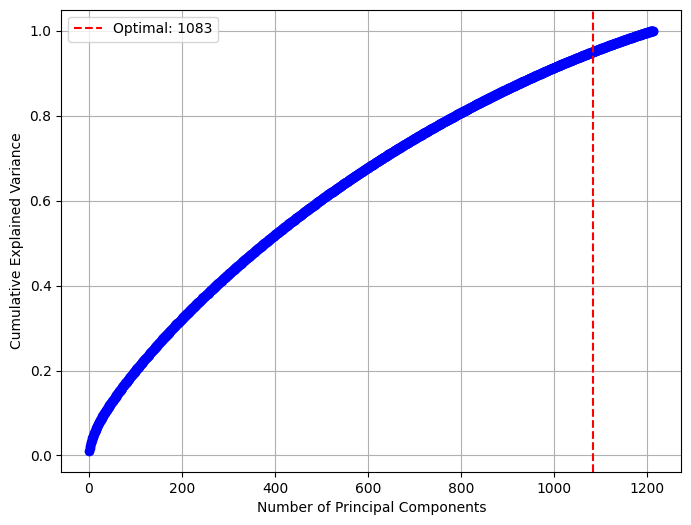

In [10]:
# X_pca, n_components, pca_model = optimal_pca(preprocessed_df, variance_threshold=0.95)
X_pca, n_components, pca_model = optimal_pca(df_numeric, variance_threshold=0.95)


In [42]:
tangent_df.to_csv('NILEARN_TRAIN_CONNECTOME_MATRICES.csv')

In [43]:
tangent_df

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,0throw_11thcolumn,0throw_12thcolumn,0throw_13thcolumn,0throw_14thcolumn,0throw_15thcolumn,0throw_16thcolumn,0throw_17thcolumn,0throw_18thcolumn,0throw_19thcolumn,...,193throw_195thcolumn,193throw_196thcolumn,193throw_197thcolumn,193throw_198thcolumn,193throw_199thcolumn,194throw_195thcolumn,194throw_196thcolumn,194throw_197thcolumn,194throw_198thcolumn,194throw_199thcolumn,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.101022,0.054926,-0.154772,0.096214,0.249178,-0.198960,-0.094001,0.151208,-0.174601,-0.007791,0.141762,0.041745,-0.028348,0.133192,-0.202025,-0.117452,-0.057958,-0.026317,-0.042448,...,-0.102007,-0.022200,-0.132998,-0.108527,-0.324609,-0.209109,-0.071042,-0.120117,-0.011920,-0.157516,-0.030031,0.073256,-0.099689,-0.118882,-0.180527,-0.078343,0.012590,-0.172432,0.037435,-0.084055
1,WHWymJu6zNZi,0.122230,0.056769,-0.047728,0.056097,-0.127519,-0.041735,-0.007272,0.094992,-0.056742,-0.060397,-0.141422,-0.072457,-0.071930,0.004040,-0.144164,-0.035641,0.005950,-0.008596,0.188953,...,0.191798,-0.021000,0.096652,-0.114323,0.021517,0.092080,0.092022,-0.089284,-0.019120,0.091371,0.113201,-0.007543,0.244155,-0.129088,-0.114314,-0.113888,0.078191,-0.164014,0.020902,-0.098770
2,4PAQp1M6EyAo,-0.308340,-0.027422,-0.012344,-0.157283,-0.140267,0.068443,0.120067,-0.100586,-0.011263,0.064309,0.185111,-0.125739,0.156043,0.114743,0.111292,-0.126685,0.058348,-0.133538,-0.009928,...,-0.004022,0.007914,0.051432,-0.028130,-0.005662,-0.201871,-0.138744,0.063696,-0.176898,-0.028564,0.112229,0.161288,0.135180,0.032028,-0.079816,-0.117984,0.018543,0.112418,0.044388,0.084359
3,obEacy4Of68I,-0.045572,0.169560,-0.251302,0.208490,0.136651,0.065789,0.099150,0.089235,0.026403,0.070220,0.060576,0.027040,0.040679,-0.042165,-0.045027,0.065106,-0.017925,0.109980,0.030638,...,0.050474,0.107645,-0.037887,0.056038,0.139357,-0.022165,-0.052453,-0.013050,0.081960,-0.111480,-0.007502,-0.126293,0.280186,0.134134,-0.061338,-0.191105,-0.035467,-0.037032,-0.019581,0.048597
4,s7WzzDcmDOhF,-0.063304,0.031032,-0.098933,0.170767,-0.008600,-0.168171,0.168250,0.013599,0.037975,0.008539,0.183968,0.037089,0.069946,0.112153,0.147815,-0.038292,0.161990,-0.012802,0.136628,...,0.110358,-0.073184,0.013449,-0.029384,0.078402,-0.076013,-0.169235,0.008484,0.201942,0.243483,0.011719,0.189002,0.145624,-0.052632,-0.090817,-0.083570,-0.265733,-0.058630,-0.214282,-0.234857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,9gpepMI9sj5q,-0.168547,-0.019849,0.223910,-0.000995,0.072722,0.032494,0.031000,0.140192,0.079403,0.007911,0.002555,0.088919,0.031755,-0.032815,-0.010798,-0.345450,0.006988,0.024754,-0.038176,...,0.017088,-0.024586,-0.019574,-0.133864,0.016872,0.094087,0.038330,0.009397,-0.003892,0.013508,-0.038743,-0.025821,-0.020123,0.060362,0.107471,0.077351,-0.012606,-0.164008,-0.210326,0.093006
1209,FIDen5rdMc0v,-0.165341,-0.021854,0.190654,0.132294,-0.180187,-0.128471,0.003125,-0.265026,-0.138462,0.035112,0.024061,-0.057902,-0.063611,0.076919,0.106174,-0.074630,0.204811,0.117493,0.199098,...,0.103734,-0.047607,0.062099,-0.121915,0.090737,0.020330,0.094850,-0.203517,0.264500,-0.071704,0.069242,-0.161445,-0.152151,-0.068047,0.155331,-0.089491,-0.104154,-0.039697,-0.073018,-0.168121
1210,dlsMC4TXL4e8,-0.013547,-0.092419,0.227788,-0.156572,-0.229294,0.102014,-0.204973,-0.066139,0.168239,0.167601,-0.177659,0.007839,0.091802,0.103232,0.213241,0.008794,0.122089,-0.032590,-0.082645,...,-0.048403,0.001757,0.031330,0.074130,0.280962,-0.061803,0.003688,-0.031292,-0.114139,0.011438,-0.079199,0.016090,-0.061

In [11]:
df_test = pd.read_csv('TEST\TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')
# df_test.head() 
participant_ids_test = df_test.iloc[:, 0]  

fc_test = df_test.iloc[:, 1:].values

In [12]:
from joblib import load

def process_test_to_tangent_space(df, tangent_measure):
    """
    Processes test data using pre-fitted tangent measure.
    
    Args:
        df: Test DataFrame with same structure as training
        tangent_measure: Pre-fitted ConnectivityMeasure object
        
    Returns:
        tangent_df: Transformed test data
    """
    # Extract data
    participant_ids = df['participant_id']
    lower_tri_data = df.drop(columns=['participant_id']).values
    
    # Validate dimensions
    n_regions = 200
    n_connections = lower_tri_data.shape[1]
    expected_connections = (n_regions * (n_regions - 1)) // 2
    if n_connections != expected_connections:
        raise ValueError(f"Expected {expected_connections} connections, got {n_connections}")

    # Reconstruct full matrices (same as training)
    full_matrices = np.zeros((len(df), n_regions, n_regions))
    triu_idx = np.triu_indices(n_regions, k=1)
    
    for i in range(len(df)):
        mat = np.eye(n_regions)
        mat[triu_idx] = lower_tri_data[i]
        mat = mat + mat.T - np.eye(n_regions)
        full_matrices[i] = mat

    # Transform using pre-fitted measure
    tangent_features = tangent_measure.transform(full_matrices)

    # Extract lower triangular
    tril_idx = np.tril_indices(n_regions, k=-1)
    tangent_lower_tri = np.array([mat[tril_idx] for mat in tangent_features])
    
    # Create output DataFrame
    tangent_df = pd.DataFrame(tangent_lower_tri, columns=df.columns[1:])
    tangent_df.insert(0, 'participant_id', participant_ids)
    
    return tangent_df

In [13]:
tangent_measure = load('tangent_measure.joblib')

test_tangent_df = process_test_to_tangent_space(df_test, tangent_measure)
# test_tangent_df.to_csv('NILEARN_TEST_CONNECTOME_MATRICES.csv')

In [41]:
test_tangent_df.to_csv('NILEARN_TEST_CONNECTOME_MATRICES.csv')

In [14]:
test_tangent_df.head()

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,0throw_11thcolumn,0throw_12thcolumn,0throw_13thcolumn,0throw_14thcolumn,0throw_15thcolumn,0throw_16thcolumn,0throw_17thcolumn,0throw_18thcolumn,0throw_19thcolumn,...,193throw_195thcolumn,193throw_196thcolumn,193throw_197thcolumn,193throw_198thcolumn,193throw_199thcolumn,194throw_195thcolumn,194throw_196thcolumn,194throw_197thcolumn,194throw_198thcolumn,194throw_199thcolumn,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,0.189142,-0.010489,-0.036802,0.071445,0.141213,-0.137685,-0.057981,-0.019387,-0.060036,-0.087991,-0.012104,0.156645,-0.020932,0.079434,0.012480,0.052665,0.122207,0.152551,-0.020107,...,0.045100,0.075753,0.143542,0.129849,-0.093495,0.326926,0.017626,0.014641,0.164039,-0.025373,-0.208870,-0.108553,-0.024329,0.076902,0.017098,0.012250,0.037627,-0.304144,0.055049,-0.010815
1,vhGrzmvA3Hjq,0.072270,-0.196857,0.220620,-0.157857,-0.014697,-0.228773,-0.168772,0.084664,-0.013440,0.201963,-0.084460,0.144044,-0.128630,0.073870,-0.053554,-0.066160,-0.106612,-0.131699,0.022865,...,0.017825,0.169973,0.070464,0.125232,0.010637,-0.001255,0.126376,-0.028763,-0.090305,0.114371,0.041147,0.194479,0.053150,-0.216235,-0.060514,0.013822,-0.043723,0.227815,0.025153,-0.225251
2,ULliyEXjy4OV,0.012402,0.002230,0.012362,-0.272486,0.084692,-0.003720,0.016100,-0.033226,0.194090,-0.173760,-0.179744,0.242351,0.173109,0.220986,-0.132140,-0.255813,-0.057840,-0.128443,-0.057561,...,0.006208,-0.059852,-0.127072,0.013927,0.150268,-0.043940,0.007395,0.065805,0.168060,-0.054875,0.056312,-0.073553,0.003685,0.072437,0.055571,0.035583,0.129212,0.056837,0.027541,0.091980
3,LZfeAb1xMtql,-0.163018,0.247165,-0.090432,-0.011114,-0.022441,0.125261,0.040358,0.019180,0.080498,-0.193671,0.068546,-0.001552,0.159406,0.007642,0.031473,0.140934,-0.054728,0.126748,-0.061810,...,-0.032868,-0.115111,-0.069727,0.000123,0.137900,0.014209,0.068879,0.074501,-0.037996,0.098473,0.065767,0.101792,0.152624,0.022289,-0.185161,-0.164966,-0.240599,0.138879,0.153826,-0.005059
4,EnFOUv0YK1RG,-0.058115,-0.061703,-0.086094,0.208747,-0.231884,-0.133487,-0.058915,0.020427,-0.097628,-0.036465,-0.122611,0.006214,0.032474,-0.007184,0.045277,-0.016264,-0.192517,-0.040167,0.029194,...,0.161632,0.181743,0.344365,-0.004246,0.225855,-0.157325,0.167303,0.056005,0.070419,0.103211,-0.095278,0.002613,0.004149,0.037052,0.251900,0.121670,0.124858,0.040464,-0.171548,0.116137


In [17]:
from sklearn.decomposition import PCA
import pandas as pd

def apply_pca(train_data, test_data=None, n_components=None):
    """
    Applies PCA on the training data (excluding participant_id) 
    and optionally transforms the test data.
    """
    train_ids = train_data['participant_id']
    train_features = train_data.drop(columns=['participant_id'])

    pca = PCA(n_components=n_components)
    train_pca = pca.fit_transform(train_features)

    
    pca_columns = [f'PCA{i+1}' for i in range(train_pca.shape[1])]
    df_train_pca = pd.DataFrame(train_pca, columns=pca_columns)
    
    df_train_pca.insert(0, 'participant_id', train_ids)

    df_test_pca = None
    if test_data is not None:
        test_ids = test_data['participant_id']
        test_features = test_data.drop(columns=['participant_id'])

        test_pca = pca.transform(test_features)
        df_test_pca = pd.DataFrame(test_pca, columns=pca_columns)

        df_test_pca.insert(0, 'participant_id', test_ids)

    return df_train_pca, df_test_pca, pca


In [ ]:
df_train_pca, df_test_pca, trained_pca = apply_pca(train_data=tangent_df,test_data=test_tangent_df, n_components=801)

In [37]:
df_test_pca.head()

,participant_id,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,...,PCA786,PCA787,PCA788,PCA789,PCA790,PCA791,PCA792,PCA793,PCA794,PCA795,PCA796,PCA797,PCA798,PCA799,PCA800,PCA801,PCA802,PCA803,PCA804,PCA805
0,Cfwaf5FX7jWK,1.179367,-0.850099,0.840548,0.136501,-0.370715,0.061268,-0.874595,0.110126,-0.108893,-0.106822,-0.225349,-0.369859,-0.029489,-0.123583,0.562542,0.001804,0.700845,0.178945,0.003297,...,-0.129863,-0.099145,-0.004652,0.163080,0.207126,-0.048508,0.057144,0.092880,0.368238,0.019236,-0.108846,0.045867,-0.113503,-0.057344,0.000887,-0.129650,0.036516,-0.095097,0.048823,-0.155837
1,vhGrzmvA3Hjq,0.006450,0.051302,0.414166,0.390839,-0.651869,-0.556554,0.949812,0.545127,-0.570355,-0.160591,0.485106,0.195792,0.709353,-0.149455,-0.275263,-0.362163,0.483694,0.318259,0.589663,...,0.151155,-0.069906,0.074823,0.010460,0.059367,0.022806,0.162659,-0.063853,0.082939,-0.019569,0.009290,-0.192420,0.053666,-0.073358,-0.071587,-0.017365,0.012331,0.083574,0.098519,-0.158169
2,ULliyEXjy4OV,0.066380,-0.546672,-0.799609,-0.559989,-0.429084,-0.322130,0.096274,-0.433657,0.078945,1.015425,0.020782,-0.093319,-0.125119,-0.392019,-0.236574,0.753727,-0.024225,-0.125233,0.208097,...,-0.069741,-0.146224,0.133058,-0.057268,-0.030871,-0.070441,0.051799,0.083779,0.107398,-0.251186,0.100306,0.063837,0.080288,0.074248,0.107673,0.017192,0.118002,0.001237,-0.052458,0.042773
3,LZfeAb1xMtql,0.636544,-1.060739,0.686187,-0.457124,-1.509480,0.362122,-0.131219,-0.768914,0.176735,0.302260,-0.297238,-0.528744,-0.523972,0.306178,0.526168,0.314989,-0.122084,-0.016015,-0.272846,...,-0.092202,-0.005460,0.163511,0.007508,0.095507,0.154550,0.012843,0.019427,0.085665,-0.101107,-0.023509,0.049564,0.242515,-0.006832,-0.112358,-0.130799,0.111595,0.025077,-0.106064,0.018874
4,EnFOUv0YK1RG,1.738639,0.512060,1.010778,-0.331596,-0.191989,0.057214,-0.116566,0.370379,0.147304,-0.246994,1.049061,0.229421,-0.302305,0.047899,0.082779,0.328657,0.061619,-0.063908,-0.265231,...,-0.077517,0.048035,-0.100174,-0.006432,-0.339818,-0.138902,0.129771,0.103981,-0.102328,0.037506,-0.239582,0.171243,-0.082337,-0.004230,0.117432,0.146825,0.006020,0.100776,-0.158371,-0.217905


In [38]:
#Save the training data into a CSV file. 
# df_train_pca.insert(0, 'participant_id', participant_ids_train)
df_train_pca.to_csv('NILEARN_805TRAINING_ADHD.csv')

In [39]:
#Save the testing data into a CSV file. 
# df_test_pca.insert(0, 'participant_id', participant_ids_test)
df_test_pca.to_csv('NILEARN_805TESTING_ADHD.csv')

In [40]:
df_test_pca 

,participant_id,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,...,PCA786,PCA787,PCA788,PCA789,PCA790,PCA791,PCA792,PCA793,PCA794,PCA795,PCA796,PCA797,PCA798,PCA799,PCA800,PCA801,PCA802,PCA803,PCA804,PCA805
0,Cfwaf5FX7jWK,1.179367,-0.850099,0.840548,0.136501,-0.370715,0.061268,-0.874595,0.110126,-0.108893,-0.106822,-0.225349,-0.369859,-0.029489,-0.123583,0.562542,0.001804,0.700845,0.178945,0.003297,...,-0.129863,-0.099145,-0.004652,0.163080,0.207126,-0.048508,0.057144,0.092880,0.368238,0.019236,-0.108846,0.045867,-0.113503,-0.057344,0.000887,-0.129650,0.036516,-0.095097,0.048823,-0.155837
1,vhGrzmvA3Hjq,0.006450,0.051302,0.414166,0.390839,-0.651869,-0.556554,0.949812,0.545127,-0.570355,-0.160591,0.485106,0.195792,0.709353,-0.149455,-0.275263,-0.362163,0.483694,0.318259,0.589663,...,0.151155,-0.069906,0.074823,0.010460,0.059367,0.022806,0.162659,-0.063853,0.082939,-0.019569,0.009290,-0.192420,0.053666,-0.073358,-0.071587,-0.017365,0.012331,0.083574,0.098519,-0.158169
2,ULliyEXjy4OV,0.066380,-0.546672,-0.799609,-0.559989,-0.429084,-0.322130,0.096274,-0.433657,0.078945,1.015425,0.020782,-0.093319,-0.125119,-0.392019,-0.236574,0.753727,-0.024225,-0.125233,0.208097,...,-0.069741,-0.146224,0.133058,-0.057268,-0.030871,-0.070441,0.051799,0.083779,0.107398,-0.251186,0.100306,0.063837,0.080288,0.074248,0.107673,0.017192,0.118002,0.001237,-0.052458,0.042773
3,LZfeAb1xMtql,0.636544,-1.060739,0.686187,-0.457124,-1.509480,0.362122,-0.131219,-0.768914,0.176735,0.302260,-0.297238,-0.528744,-0.523972,0.306178,0.526168,0.314989,-0.122084,-0.016015,-0.272846,...,-0.092202,-0.005460,0.163511,0.007508,0.095507,0.154550,0.012843,0.019427,0.085665,-0.101107,-0.023509,0.049564,0.242515,-0.006832,-0.112358,-0.130799,0.111595,0.025077,-0.106064,0.018874
4,EnFOUv0YK1RG,1.738639,0.512060,1.010778,-0.331596,-0.191989,0.057214,-0.116566,0.370379,0.147304,-0.246994,1.049061,0.229421,-0.302305,0.047899,0.082779,0.328657,0.061619,-0.063908,-0.265231,...,-0.077517,0.048035,-0.100174,-0.006432,-0.339818,-0.138902,0.129771,0.103981,-0.102328,0.037506,-0.239582,0.171243,-0.082337,-0.004230,0.117432,0.146825,0.006020,0.100776,-0.158371,-0.217905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,2.106383,-0.148286,0.764477,-1.025793,-0.702575,0.222508,-0.978334,-0.596138,0.428114,0.222462,0.448201,0.417653,0.193374,0.483431,0.342101,0.042194,-0.491516,0.185368,0.121743,...,-0.003481,0.195421,0.151251,0.012766,0.114449,-0.168606,0.023272,0.160452,-0.046946,0.179341,0.044901,0.144931,0.111723,-0.167632,0.131067,-0.023613,0.115287,-0.005224,0.078833,-0.049186
300,IUEHiLmQAqCi,1.074660,-0.785743,-0.575990,-0.334448,-0.272293,-1.148931,0.541596,0.571786,-0.038637,-0.599519,-1.213207,0.222342,0.360938,-0.106479,-0.082405,-1.045253,1.037087,-0.402905,0.313623,...,0.216571,0.087756,-0.094867,-0.157705,-0.122374,-0.060095,0.021316,-0.165421,-0.040518,-0.199254,-0.067912,-0.029013,0.252776,-0.198720,0.189566,-0.234923,0.010982,-0.125673,-0.096414,-0.065602
301,cRySmCadYFRO,1.783831,1.423658,0.350233,0.482447,-0.517440,0.026473,-0.048401,-0.096741,0.124699,0.814405,0.208909,0.058798,-0.009085,0.697089,-0.006873,-0.825280,0.826123,-0.415190,0.257717,...,-0.133675,0.151072,-0.114791,0.079462,0.148990,-0.070640,-0.081462,0.099442,-0.073613,0.096881,-0.082588,-0.090697,0.051897,0.061074,0.131981,-0.032139,-0.046538,-0.094594,-0.036660,-0.188410
302,E3MvDUtJadc5,-1.376627,-2.336665,0.242378,-0.810319,-0.282612,0.208404,-0.329714,0.180301,-0.240880,-0.268781,0.667503,0.282180,0.285518,0.370973,-0.054021,-0.469246,-0.634229,-0.767757,1.186979,...,0.043245,-0.080536,0.015247,0.095405,-0.067845,-0.133801,0.282189,0.006687,-0.095381,0.117461,-0.002887,-0.006796,0.067038,-0.011671,0.067314,-0.031760,-0.020614,0.211955,0.039071,-0.013757


#### `TESTING DATA`

In [2]:
df_test = pd.read_csv('TEST\TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')
df_test.head()

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,0throw_11thcolumn,0throw_12thcolumn,0throw_13thcolumn,0throw_14thcolumn,0throw_15thcolumn,0throw_16thcolumn,0throw_17thcolumn,0throw_18thcolumn,0throw_19thcolumn,...,193throw_195thcolumn,193throw_196thcolumn,193throw_197thcolumn,193throw_198thcolumn,193throw_199thcolumn,194throw_195thcolumn,194throw_196thcolumn,194throw_197thcolumn,194throw_198thcolumn,194throw_199thcolumn,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,0.548480,0.713607,0.557319,0.524369,0.693364,0.770032,0.724406,0.390118,0.547912,0.470220,0.577032,-0.119497,-0.280841,-0.019035,-0.122865,-0.260158,-0.080816,-0.169178,0.044282,...,0.177253,0.401979,0.106004,0.423125,0.020117,0.425365,0.469552,0.147880,0.273439,0.042834,0.080423,-0.054581,-0.088163,-0.028574,0.444847,0.350149,-0.012601,0.665750,0.560565,0.555732
1,vhGrzmvA3Hjq,0.427740,0.363022,0.402862,0.363003,0.534558,0.345347,0.409471,0.303328,0.402515,0.275052,0.556938,-0.208563,-0.066622,-0.374807,-0.203328,-0.128250,0.129341,-0.048327,-0.168644,...,0.379247,0.006668,-0.212718,-0.097964,0.055697,0.563455,0.321669,0.026832,0.131396,0.342759,0.198009,-0.000724,0.083122,0.033043,0.687497,0.306229,0.717485,0.461809,0.559632,0.350027
2,ULliyEXjy4OV,0.139572,0.390106,-0.087041,0.196852,0.088148,0.023843,0.381782,0.068979,0.377488,0.301871,0.130841,0.112161,-0.041427,0.162259,-0.103795,-0.234537,0.075495,-0.167188,0.355339,...,-0.096903,-0.028224,-0.033103,0.027181,0.094545,0.528172,0.080640,-0.008889,-0.113136,0.049962,0.051319,0.023630,-0.056819,0.117396,0.576086,0.517831,0.527044,0.605038,0.609856,0.750987
3,LZfeAb1xMtql,0.133561,0.778326,0.416355,0.471840,0.568460,0.633660,0.501113,0.345461,0.467943,0.417308,0.413740,0.051334,-0.223290,-0.035691,-0.140884,-0.273919,-0.148932,-0.045097,-0.164163,...,0.413913,0.005596,-0.217062,0.034785,-0.273236,0.569694,0.039745,-0.275454,0.090846,-0.215843,0.046183,-0.238962,0.121868,-0.260970,0.646818,0.594902,0.608156,0.595459,0.683189,0.542296
4,EnFOUv0YK1RG,0.126699,0.575446,0.509422,0.363193,0.427544,0.449924,0.451796,0.223927,0.298248,0.304429,0.359301,-0.147870,-0.090376,-0.047171,-0.131151,-0.242002,-0.309398,-0.169008,-0.237186,...,0.422525,0.131058,-0.110349,0.275598,0.471873,0.673370,0.409451,0.067518,0.179088,0.502649,0.315734,0.002234,0.290791,0.344149,0.480214,0.539824,0.447322,0.293088,0.148529,0.539823


In [3]:
participant_ids_test = df_test.iloc[:, 0]  

fc_matrices_flat_test = df_test.iloc[:, 1:].values

# fc_matrices_test = np.array([upper_to_full_matrix(row, n_regions) for row in fc_matrices_flat_test])

### **Peform a Correlation matrix on the supplimentary Training & Testing data to find the top most features that have high variance.**

This is a necessary step because we want to find the top most features which we will add to our features.  This is because not all features will contribute to the performance of the model. 

In [4]:
df_train_supp = pd.read_csv('suplimentary_train.csv')
# df_train_sol = pd.read_excel('TRAIN\TRAINING_SOLUTIONS.
df_train_supp

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,ADHD_Outcome,Sex_F
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN,1,0
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0,1,0
2,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0,0,1
3,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN,1,0
4,0cduHhwrQN4r,-100.00,14.0,5.0,16.0,36.0,19.0,13.0,22.0,6.0,22.0,1.0,16.0,5.0,10.0,6.0,5.0,6.0,NaN,2017,1,0.0,0.0,2.0,18.0,25.0,15.0,40.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,7CkP21xwNO4M,13.34,14.0,6.0,11.0,48.0,26.0,10.0,30.0,3.0,7.0,0.0,6.0,2.0,3.0,1.0,1.0,10.0,NaN,2019,3,0.0,1.0,3.0,18.0,30.0,15.0,30.0,0,0
1209,CgU9hobPWpRo,-53.34,14.0,3.0,9.0,46.0,22.0,10.0,28.0,6.0,27.0,6.0,16.0,6.0,10.0,11.0,5.0,3.0,9.630390,2018,3,0.0,0.0,2.0,18.0,0.0,NaN,NaN,1,0
1210,7XJZtiSVaOtC,80.00,14.0,3.0,15.0,36.0,16.0,11.0,22.0,2.0,7.0,0.0,7.0,0.0,5.0,0.0,0.0,5.0,8.327287,2018,1,0.0,0.0,3.0,18.0,30.0,18.0,30.0,1,0
1211,HG0Pu8QHXKut,33.35,12.0,4.0,16.0,42.0,15.0,12.0,30.0,0.0,11.0,4.0,5.0,3.0,5.0,6.0,2.0,9.0,8.103239,2017,1,1.0,2.0,2.0,15.0,40.0,9.0,20.0,0,1


In [5]:
merge_sol_copy = df_train_supp.copy()
merge_sol_copy.drop(columns=['participant_id'], axis=1, inplace=True)

In [6]:
top = merge_sol_copy.corr()['ADHD_Outcome'].sort_values(ascending=False).head(10)
top

ADHD_Outcome                  1.000000
SDQ_SDQ_Hyperactivity         0.558625
SDQ_SDQ_Externalizing         0.514630
SDQ_SDQ_Difficulties_Total    0.464724
SDQ_SDQ_Generating_Impact     0.410349
SDQ_SDQ_Conduct_Problems      0.275598
SDQ_SDQ_Internalizing         0.257269
SDQ_SDQ_Peer_Problems         0.219253
SDQ_SDQ_Emotional_Problems    0.205459
Basic_Demos_Enroll_Year       0.166252
Name: ADHD_Outcome, dtype: float64

In [7]:
top_gender = merge_sol_copy.corr()['Sex_F'].sort_values(ascending=False).head(10)
top_gender 

Sex_F                          1.000000
SDQ_SDQ_Prosocial              0.123535
SDQ_SDQ_Emotional_Problems     0.108491
ColorVision_CV_Score           0.106389
SDQ_SDQ_Internalizing          0.057341
Barratt_Barratt_P1_Occ         0.049121
Barratt_Barratt_P1_Edu         0.041997
Barratt_Barratt_P2_Edu         0.008790
EHQ_EHQ_Total                  0.000689
PreInt_Demos_Fam_Child_Race   -0.000485
Name: Sex_F, dtype: float64

In [8]:
merge_df = df_train_supp[['participant_id','SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Externalizing','SDQ_SDQ_Difficulties_Total',
                       'SDQ_SDQ_Generating_Impact']]

In [9]:
training_data = pd.read_csv('nilearn_800FULL_TRAINING.csv')

In [10]:
data_merge = training_data.merge(merge_df, on='participant_id', how='left')

In [11]:
data_merge.head()

,participant_id,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,...,PCA787,PCA788,PCA789,PCA790,PCA791,PCA792,PCA793,PCA794,PCA795,PCA796,PCA797,PCA798,PCA799,PCA800,ADHD_Outcome,Sex_F,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Externalizing,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Generating_Impact
0,WHWymJu6zNZi,2.013580,0.101671,0.028799,-0.104857,0.586896,-1.328376,-0.661889,-0.865322,-0.079058,-0.878691,0.572012,-0.739930,0.110565,0.230615,1.039403,-0.725882,-1.314656,-0.051667,0.318821,...,-1.000286,0.188620,-0.065588,-0.799366,0.219578,-1.150428,0.148885,0.521680,0.243951,-0.127085,0.665604,0.023788,-0.170777,-0.424322,1,1,NaN,NaN,NaN,NaN
1,4PAQp1M6EyAo,1.445007,1.342919,1.024132,-0.754576,-0.451917,0.295019,0.267390,0.834481,0.232190,-0.607036,-0.321730,-0.211839,1.051224,-1.223697,0.474532,-0.330185,-0.523632,0.359508,-0.673348,...,-0.191121,0.314841,-0.449913,-0.146420,-0.381538,-0.270007,-0.762281,-0.554808,-0.255315,-0.486812,-0.299144,-0.103812,0.820048,-0.569216,1,1,9.0,17.0,26.0,8.0
2,obEacy4Of68I,-2.367461,-0.649452,0.815148,-0.776183,0.451482,-0.912429,0.342336,0.411811,0.670943,-0.141410,0.670921,0.477580,-0.597786,0.290325,-1.148751,1.314385,0.005356,0.954137,-0.167945,...,-0.271835,-0.460206,0.425879,0.538823,0.224320,-0.646132,0.107527,0.144787,0.128441,-0.337049,-0.393792,-0.465377,0.316403,0.940707,1,1,4.0,4.0,7.0,1.0
3,s7WzzDcmDOhF,0.525255,0.769679,0.608043,-0.529955,1.209090,-0.718566,-0.409636,-0.463969,-0.232278,0.071967,-0.100426,-0.301126,0.650949,0.344697,-1.121468,-1.140412,0.688571,-0.701287,-1.797260,...,0.159247,-0.076786,0.084299,-0.345521,-0.344833,0.217646,0.127461,0.082923,0.081741,-0.155078,0.123894,0.101344,0.040583,-0.073481,1,1,3.0,6.0,14.0,3.0
4,sId1cQF5F22m,-0.186627,-1.883094,-0.823645,0.649690,0.980071,-1.613735,-0.145921,-2.080992,-0.279344,-1.010531,0.256626,-0.351177,-0.239736,-0.246335,-1.325621,-0.098588,0.708640,-1.084212,0.494870,...,-0.034681,0.156317,-0.122457,0.163031,0.355366,-0.342326,-0.388883,0.242261,-0.115445,-0.104173,0.377231,-0.137311,0.118573,0.061776,0,0,4.0,8.0,17.0,2.0


In [12]:
data_merge.to_csv('full_nilearn_800FULL_TRAINING.csv')

<Axes: >

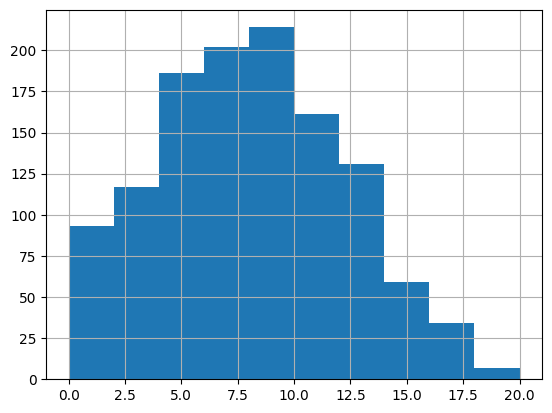

In [16]:
data_merge['SDQ_SDQ_Externalizing'].hist(bins=10)

2. 

In [2]:
df_train_supp2 = pd.read_csv('suplimentary_test.csv')

test_cols = df_train_supp2[['participant_id','SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Externalizing','SDQ_SDQ_Difficulties_Total',
                       'SDQ_SDQ_Generating_Impact']]

In [3]:
merge_test = pd.read_csv('NILEARN_800TESTING_ADHD.csv')

In [4]:
data_merge_test = merge_test.merge(test_cols, on='participant_id', how='left')

In [5]:
data_merge_test.head()

,Unnamed: 0,participant_id,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,...,PCA785,PCA786,PCA787,PCA788,PCA789,PCA790,PCA791,PCA792,PCA793,PCA794,PCA795,PCA796,PCA797,PCA798,PCA799,PCA800,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Externalizing,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Generating_Impact
0,0,Cfwaf5FX7jWK,1.179367,-0.850095,0.840537,0.136525,-0.370720,0.061228,-0.874617,0.110075,-0.108926,-0.106693,-0.225540,-0.369847,-0.029560,-0.123563,0.562817,0.001629,0.701425,0.179267,...,0.229552,-0.205377,-0.083158,0.033199,0.035145,0.112894,0.120275,-0.008993,0.010106,-0.080914,-0.131737,0.043188,-0.008022,0.041498,-0.133031,0.140495,7.0,9.0,12.0,2.0
1,1,vhGrzmvA3Hjq,0.006450,0.051295,0.414163,0.390829,-0.651887,-0.556570,0.949837,0.545107,-0.570396,-0.160604,0.485277,0.195754,0.709698,-0.149626,-0.275751,-0.362378,0.483921,0.318254,...,0.108943,0.033820,-0.194829,0.089262,-0.133273,-0.037276,-0.160481,0.058359,-0.083073,-0.070007,0.111956,-0.200373,-0.089889,-0.154600,-0.019765,-0.095240,3.0,5.0,16.0,7.0
2,2,ULliyEXjy4OV,0.066380,-0.546673,-0.799626,-0.559976,-0.429086,-0.322116,0.096232,-0.433705,0.078816,1.015508,0.020739,-0.093051,-0.124995,-0.391808,-0.237039,0.753989,-0.023694,-0.125585,...,0.017355,0.003807,0.218532,0.334830,0.091319,-0.115727,0.060790,0.072804,-0.098362,-0.153316,-0.031831,0.081679,-0.180389,0.000943,-0.257759,0.158364,5.0,6.0,7.0,1.0
3,3,LZfeAb1xMtql,0.636544,-1.060740,0.686172,-0.457119,-1.509502,0.362074,-0.131243,-0.768844,0.176816,0.302173,-0.297290,-0.528950,-0.523910,0.305972,0.526496,0.315429,-0.121761,-0.015980,...,-0.109901,0.207692,0.085995,0.083351,0.022789,-0.048896,-0.012848,0.074476,-0.045623,-0.005584,-0.108352,0.017851,0.103185,-0.034626,0.130027,-0.166268,6.0,10.0,15.0,8.0
4,4,EnFOUv0YK1RG,1.738639,0.512055,1.010781,-0.331601,-0.191982,0.057213,-0.116557,0.370248,0.147358,-0.246817,1.048960,0.229493,-0.302254,0.048435,0.082928,0.328035,0.062164,-0.063901,...,-0.047345,-0.047649,0.046301,-0.025789,0.137871,-0.027877,0.316694,0.111749,-0.035454,0.068391,-0.178241,0.130109,-0.336052,0.105963,0.273270,-0.077985,10.0,12.0,18.0,5.0


In [6]:
#Training data awith selected SDQ features havung a high correlation with the target. 
data_merge_test.to_csv('full_nilearn_800FULL_TEST.csv')